In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
from datetime import datetime 
from alpaca_trade_api.rest import REST, TimeFrame
import time
from time import sleep
import datetime
import csv
%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()
opensea_api_key = os.getenv("opensea_api_key")
opensea_api_key

'9796bf59fe674cae9688a1a9bb422338'

In [3]:
opensea_collections_url = "https://api.opensea.io/api/v1/collections"
opensea_collection_stats_url = "https://api.opensea.io/api/v1/collection/doodles-official/stats"

In [4]:
def get_events(url,start_date, end_date, event_type, collection_slug,limit=1):
    

    headers = {
        "Accept": "application/json",
        "X-API-KEY": opensea_api_key
    }
    
    query = { 
        "only_opensea": "true", 
        "occurred_before": end_date,
        "occurred_after": start_date,
        "event_type":event_type,
        "collection_slug":collection_slug,
        "limit":limit
    }
    
    response_data = requests.request("GET", url, headers=headers, params=query)
    json_data = response_data.json()
    #print(json_data)
    return json_data

In [5]:
#get_opensea_api_data(opensea_collections_url)
#get_opensea_api_data(opensea_collection_stats_url)

start_date = datetime.datetime(2022, 1, 10)
end_date = datetime.datetime(2022, 4, 11)
event_url = "https://api.opensea.io/api/v1/events";
event_type = "successful"
collection_slug = "boredapeyachtclub"
limit =10


#print(response_data)
#print(response_data['asset_events'])


In [6]:
def parse_event(event):
    record = {}
    asset = event.get('asset')
    if asset == None:
        return None # if there's no asset that means it's not a single NFT transaction so skip this item

    #collection
    record['collection_slug'] = asset['collection']['slug']
    record['collection_name'] = asset['collection']['name']
    record['collection_url'] = "https://opensea.io/collection/" + asset['collection']['slug']

    #asset
    record['asset_id'] = asset['id']
    record['asset_name'] = asset['name']
    record['asset_description'] = asset['description']
    record['asset_contract_date'] = asset['asset_contract']['created_date']
    record['asset_url'] = asset['permalink']
    record['asset_img_url'] = asset['image_url']

    #event
    record['event_id'] = event['id']
    record['event_time'] = event.get('created_date')
    record['event_auction_type'] = event.get('auction_type')
    record['event_contract_address'] = event.get('contract_address')
    record['event_quantity'] = event.get('quantity')
    record['event_payment_symbol'] =  None if event.get('payment_token') == None else event.get('payment_token').get('symbol')

    decimals = 18
    if event.get('payment_token') != None:
        decimals = event.get('payment_token').get('decimals')

    price_str = event['total_price']

    try: 
        if len(price_str) < decimals:
            price_str =  "0." + (decimals-len(price_str)) * "0" + price_str
            record['event_total_price'] = float(price_str)
        else:
            record['event_total_price'] = float(price_str[:-decimals] + "." + price_str[len(price_str)-decimals:])
    except:
        print(event)

    return record

In [7]:
pause = 1

def fetch_all_events(url,start_date, end_date,event_type,collection_slug,limit):
    result = list()
    print(f"Fetching events between {start_date} and {end_date}")
    response = get_events(url,start_date,end_date,event_type,collection_slug, limit)
    for event in response['asset_events']:
        cleaned_event = parse_event(event)
        if cleaned_event != None:
            result.append(cleaned_event)
    return result

In [8]:


start_date = datetime.datetime(2021, 2, 10)
end_date = datetime.datetime(2022, 4, 10)
limit = 300

result = fetch_all_events(event_url,start_date,end_date,event_type,collection_slug, limit)

print(f"total number of records found:{len(result)}")

Fetching events between 2021-02-10 00:00:00 and 2022-04-10 00:00:00
total number of records found:300


In [9]:
file_name="event_data.csv"

#print(result[0].keys())

def write_csv(data, file_name):
    with open(file_name, mode='w', encoding='utf-8', newline='\n') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames = data[0].keys())

        writer.writeheader()
        for event in data:
            writer.writerow(event)
            
write_csv(result, file_name)

In [10]:
nft_events_df = pd.read_csv('event_data.csv')


nft_event_price_df=nft_events_df[['asset_id','event_time','event_total_price']]

nft_event_price_df['event_time']= pd.to_datetime(nft_events_df['event_time']).dt.date
nft_event_price_df.rename(columns = {'event_time':'event_date'}, inplace = True)

#nft_event_price_df =nft_event_price_df.set_index("event_date")
nft_event_price_df

/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,asset_id,event_date,event_total_price
0,23137208,2022-04-09,101.6789
1,23131468,2022-04-09,130.0000
2,23123790,2022-04-09,110.0000
3,23134568,2022-04-09,107.0000
4,23133985,2022-04-09,125.0000
...,...,...,...
295,23132695,2022-03-18,94.0000
296,23142856,2022-03-18,94.0000
297,23140938,2022-03-18,100.0000
298,23133575,2022-03-18,90.5000


In [11]:
# this NFT collection has different assets which will have different prices based on various attributes 
# like rarity. For the sake of simplicity, we will consider the min/floor price of any of the asset
# for a particular day to determine the floor price of the collection for that day
# this function will interate though all the rows and check for different prices for a day.
# it will then pick the min of the price as the floor price for that day (irrespective of the assetId)
def consolidate_price_data_for_dates(df):
    prices_per_day={}
    for i in range(0, len(df)):
        event_date = df.iloc[i]['event_date']
        event_total_price = df.iloc[i]['event_total_price']
        #print(event_date,event_total_price )
        if event_date in prices_per_day:
            value_event_date = prices_per_day.get(event_date)
            value_event_date.append(event_total_price)
        else:
            prices_per_day[event_date]= [event_total_price]

    return prices_per_day

prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
prices_per_day

{datetime.date(2022, 4, 9): [101.6789, 130.0, 110.0, 107.0, 125.0],
 datetime.date(2022, 4, 8): [113.0, 114.0, 110.0, 130.0, 101.001, 124.0],
 datetime.date(2022, 4, 7): [125.0, 126.0, 123.99, 135.0, 129.0, 111.9],
 datetime.date(2022, 4, 6): [100.1775,
  117.0,
  112.0,
  122.0,
  129.4,
  112.0,
  124.68],
 datetime.date(2022, 4, 5): [119.69,
  120.0,
  124.54,
  111.0,
  122.388,
  133.0,
  111.0,
  118.0,
  98.85910100000004,
  180.0],
 datetime.date(2022, 4, 4): [111.0,
  118.0,
  109.99,
  109.69,
  108.9,
  100.0,
  96.85920303000005,
  120.0,
  110.0],
 datetime.date(2022, 4, 3): [105.0, 114.95, 124.0, 112.0, 125.0, 115.0],
 datetime.date(2022, 4, 2): [103.0, 200.0, 135.0, 133.333],
 datetime.date(2022, 4, 1): [102.0,
  115.0,
  111.69,
  125.0,
  121.95,
  121.5,
  111.0,
  118.5,
  125.0,
  100.0],
 datetime.date(2022, 3, 31): [125.0,
  119.5,
  114.69,
  117.9,
  115.0,
  159.0,
  115.24596696990398,
  108.5,
  110.0,
  124.5,
  108.9,
  109.0,
  140.0,
  200.0],
 datetime.d

In [12]:
# once the dictonary is created with key as date and values as different prices for that date,
# iterate over the dictionary, to get the lowest value for that date and create another dictionary

def get_floor_price_data(prices_per_day):
    floor_prices={}
    for key in prices_per_day:
        prices_for_current_day = prices_per_day[key]
        floor_price_current_day = min(prices_for_current_day)
        floor_prices[key]= floor_price_current_day
        #print(key, 'corresponds to', floor_prices[key],floor_price_current_day)
    return floor_prices

floor_prices = get_floor_price_data(prices_per_day)
floor_prices

{datetime.date(2022, 4, 9): 101.6789,
 datetime.date(2022, 4, 8): 101.001,
 datetime.date(2022, 4, 7): 111.9,
 datetime.date(2022, 4, 6): 100.1775,
 datetime.date(2022, 4, 5): 98.85910100000004,
 datetime.date(2022, 4, 4): 96.85920303000005,
 datetime.date(2022, 4, 3): 105.0,
 datetime.date(2022, 4, 2): 103.0,
 datetime.date(2022, 4, 1): 100.0,
 datetime.date(2022, 3, 31): 108.5,
 datetime.date(2022, 3, 30): 102.69,
 datetime.date(2022, 3, 29): 93.91,
 datetime.date(2022, 3, 28): 0.029,
 datetime.date(2022, 3, 27): 96.5,
 datetime.date(2022, 3, 26): 95.01,
 datetime.date(2022, 3, 25): 101.0,
 datetime.date(2022, 3, 24): 97.0,
 datetime.date(2022, 3, 23): 99.416835,
 datetime.date(2022, 3, 22): 100.69,
 datetime.date(2022, 3, 21): 87.7334,
 datetime.date(2022, 3, 20): 85.0,
 datetime.date(2022, 3, 19): 88.0,
 datetime.date(2022, 3, 18): 90.5}

<AxesSubplot:>

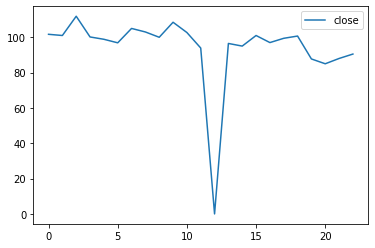

In [13]:
#df = pd.DataFrame.from_dict(floor_prices)
df =pd.DataFrame(floor_prices.items(), columns=['event_date', 'close'])
df.plot()

In [14]:
start_date = datetime.datetime(2022, 1, 10)
end_date = datetime.datetime(2022, 4, 11)
event_url = "https://api.opensea.io/api/v1/events";
event_type = "successful"
collection_slug = "boredapeyachtclub"
limit =300
file_name = collection_slug + '.csv'

def fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                        file_name):

    result = fetch_all_events(event_url,start_date,end_date,event_type,collection_slug, limit)
    write_csv(result, file_name)
    
    print(f"writing data to file:{file_name}")
    nft_events_df = pd.read_csv(file_name)
    nft_event_price_df=nft_events_df[['asset_id','event_time','event_total_price']]

    nft_event_price_df['event_time']= pd.to_datetime(nft_events_df['event_time']).dt.date
    nft_event_price_df.rename(columns = {'event_time':'event_date'}, inplace = True)

    #nft_event_price_df =nft_event_price_df.set_index("event_date")
    #nft_event_price_df
    prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
    floor_prices = get_floor_price_data(prices_per_day)
    df =pd.DataFrame(floor_prices.items(), columns=['event_date', 'close'])
    df = df.sort_values(by="event_date",axis=0, ascending=True )
    df = df.set_index('event_date')
    # Concatenate the ticker DataFrames
    df_mc = pd.concat([df], axis=1, keys=[collection_slug])
    return df_mc

In [15]:
df_boredapeyachtclub = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_boredapeyachtclub

Fetching events between 2022-01-10 00:00:00 and 2022-04-11 00:00:00
writing data to file:boredapeyachtclub.csv


/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,boredapeyachtclub
,close
event_date,
2022-03-18,95.000000
2022-03-19,88.000000
2022-03-20,85.000000
2022-03-21,87.733400
2022-03-22,100.690000
2022-03-23,99.416835
2022-03-24,97.000000
2022-03-25,101.000000


Fetching events between 2022-01-10 00:00:00 and 2022-04-11 00:00:00
writing data to file:doodles-official.csv


/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='event_date'>

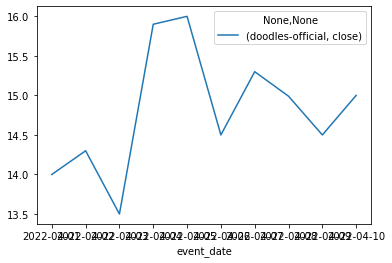

In [16]:
collection_slug = "doodles-official"
file_name = collection_slug + '.csv'

df_doodles = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_doodles.plot()

In [17]:
#prepare the datafame for Monte Carlo simulation


df = df.sort_values(by="event_date",axis=0, ascending=True )
df = df.set_index('event_date')
# Concatenate the ticker DataFrames
df_mc = pd.concat([df], axis=1, keys=["NFT"])

# Display sample data
df_mc


,NFT
,close
event_date,
2022-03-18,90.500000
2022-03-19,88.000000
2022-03-20,85.000000
2022-03-21,87.733400
2022-03-22,100.690000
2022-03-23,99.416835
2022-03-24,97.000000
2022-03-25,101.000000


In [18]:
num_of_simulation =100
num_of_years=1
num_trading_days = 252*num_of_years
num_trading_days=90

MC_1year = MCSimulation(
    portfolio_data = df_mc,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

In [19]:
# Printing the simulation input data
MC_1year.portfolio_data.head()

NFT             
               close daily_return
event_date                       
2022-03-18   90.5000          NaN
2022-03-19   88.0000    -0.027624
2022-03-20   85.0000    -0.034091
2022-03-21   87.7334     0.032158
2022-03-22  100.6900     0.147681

In [20]:
# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
MC_1year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,3.800747e+02,4.747242e+01,8.300196e+02,3.814139e+02,1.527960e+02,3.957580e+02,8.426171e+02,7.867613e+02,1.391557e+02,6.305327e+02,...,-5.109197e+02,-7.370467e+02,5.243564e+02,-3.051763e+02,1.603218e+03,8.388479e+02,1.936834e+03,4.026943e+02,-3.072140e+02,4.957650e+02
2,2.859463e+05,1.450241e+04,3.870578e+04,-1.316996e+05,-8.544280e+04,-3.090881e+04,5.641032e+05,-7.432566e+05,-8.650163e+03,5.934838e+05,...,-4.520792e+05,2.145209e+05,-5.922159e+05,-6.632864e+04,1.150818e+06,-5.963078e+05,1.698327e+06,-2.035265e+05,-4.196736e+05,-2.729378e+05
3,-3.933225e+08,-1.419312e+06,1.254822e+07,1.235622e+08,2.492996e+07,1.212645e+07,-1.452632e+08,-2.052032e+08,-4.629443e+06,3.505301e+08,...,-6.931197e+08,-1.435059e+08,-2.980316e+08,5.723389e+06,-8.728492e+08,-1.272454e+09,-2.553318e+09,-2.330144e+07,2.374082e+08,9.698268e+07
4,-4.402536e+11,-8.267102e+08,-6.152424e+08,-5.180041e+10,2.403578e+09,6.676094e+09,-3.610886e+10,7.420112e+09,3.356450e+08,1.656066e+11,...,-4.415297e+11,3.727132e+09,9.848451e+10,3.641847e+09,-5.632664e+10,1.311315e+12,1.277665e+12,-2.921643e+09,1.859896e+11,5.537836e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,-3.044278e+223,-1.495488e+220,-3.079557e+222,-2.536633e+214,3.104727e+219,-4.253501e+221,-1.082375e+226,-7.321705e+224,-4.097747e+218,1.227739e+217,...,-1.546014e+222,1.817348e+218,4.609700e+229,9.662022e+225,8.429187e+226,-3.048516e+219,1.759462e+222,-9.649770e+218,1.157549e+218,-3.106305e+221
87,-2.530727e+226,-1.326596e+223,-1.685923e+225,1.908334e+216,-1.329842e+222,9.770982e+223,5.313738e+228,-9.236468e+227,-3.262514e+221,1.771494e+220,...,-1.028129e+225,3.851245e+220,1.406283e+232,2.270062e+228,1.527299e+229,-8.777922e+221,6.654845e+224,-7.192858e+221,-2.172860e+219,5.860285e+223
88,1.667466e+229,-1.206218e+226,1.394589e+228,1.781500e+218,1.473825e+224,-4.760004e+226,-5.121156e+231,-9.803853e+230,-1.746422e+223,-4.532495e+222,...,-2.308682e+227,1.588808e+223,7.433349e+234,1.984523e+231,4.081412e+231,-4.247651e+223,8.797096e+227,-3.480126e+224,4.254565e+221,2.915691e+226
89,7.850838e+231,1.486268e+228,1.393988e+231,1.824440e+221,6.203810e+225,-2.031039e+228,-1.074461e+235,7.580707e+231,1.119229e+226,-1.601099e+225,...,1.747328e+230,1.223927e+225,9.938894e+237,-1.856781e+234,-1.827759e+234,2.779109e+226,3.046441e+230,-4.617789e+227,5.575783e+223,1.054633e+229


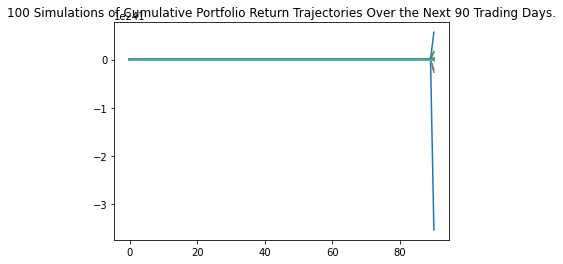

In [21]:
# Plot simulation outcomes
line_plot = MC_1year.plot_simulation()
line_plot.get_figure().savefig("MC_1year_sim_plot.png", bbox_inches="tight")

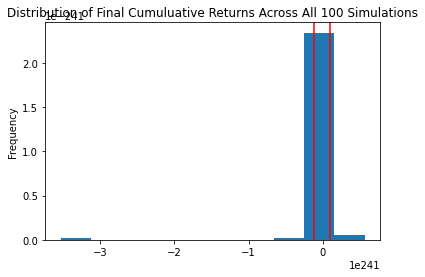

In [22]:
# Plot probability distribution and confidence intervals
dist_plot = MC_1year.plot_distribution()
dist_plot.get_figure().savefig('MC_1year_dist_plot.png',bbox_inches='tight')

In [23]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_1year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count            1.000000e+02
mean           -3.088948e+239
std                       inf
min            -3.533099e+241
25%            -6.839984e+229
50%             1.590127e+227
75%             4.714283e+232
max             5.666208e+240
95% CI Lower   -1.218927e+240
95% CI Upper    9.457710e+239
Name: 90, dtype: float64


In [24]:
num_of_simulation =100
num_of_years=1
#num_trading_days = 252*num_of_years
num_trading_days=90

doodles_MC_1year = MCSimulation(
    portfolio_data = df_doodles,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

In [25]:
# Printing the simulation input data
doodles_MC_1year.portfolio_data.head()

doodles-official             
                      close daily_return
event_date                              
2022-04-01             14.0          NaN
2022-04-02             14.3     0.021429
2022-04-03             13.5    -0.055944
2022-04-04             15.9     0.177778
2022-04-05             16.0     0.006289

In [26]:
# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
doodles_MC_1year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994748,1.048513,0.883478,1.000689,0.978192,0.992673,0.962449,1.080565,1.000274,0.980080,...,1.060135,1.020032,1.043876,0.969018,0.942800,1.083562,1.036972,0.962361,1.078622,0.969526
2,0.913216,0.914976,0.808517,0.947235,0.914595,0.944479,0.956666,1.104918,1.099092,0.994391,...,1.131514,0.953186,1.062782,0.936304,1.041375,1.117369,1.065339,0.989952,1.049256,1.048523
3,1.078674,0.823133,0.711336,0.938199,0.853791,0.747230,1.120540,0.937885,1.326329,0.964692,...,1.189424,0.855839,1.193328,1.026498,1.069173,1.065819,0.976664,0.930455,1.027385,1.077868
4,1.079212,0.925304,0.805067,1.045632,0.820095,0.786081,1.175432,0.761230,1.170095,1.034025,...,0.954295,0.925009,1.134132,0.963102,1.112609,1.097963,1.139079,0.920999,1.040881,1.151933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.149166,1.023415,0.470638,1.169566,0.489273,2.375347,2.048374,0.798302,4.132720,2.684240,...,1.495360,2.481068,0.589596,1.004227,3.341722,1.541656,2.234059,1.303261,1.218742,1.744544
87,1.179849,1.058007,0.403683,1.046063,0.466263,2.686794,2.032449,0.732953,3.989437,2.774444,...,1.519646,2.398983,0.606940,0.944809,3.702095,1.638920,2.108971,1.266556,1.356748,1.677300
88,1.026515,1.048200,0.421714,0.984936,0.429223,2.512411,2.146382,0.779745,3.730285,2.685818,...,1.508005,2.003659,0.609927,0.814231,3.201019,1.774340,2.225279,1.283825,1.429590,1.770710
89,0.949199,1.113423,0.426407,1.100024,0.440327,2.514451,2.235196,0.780960,3.508300,2.991661,...,1.635253,2.312390,0.659683,0.747825,3.596327,1.844613,1.966853,1.303071,1.368289,2.179491


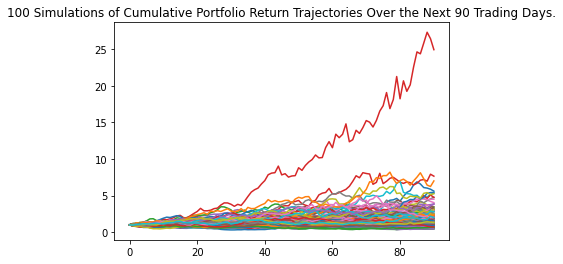

In [27]:
# Plot simulation outcomes
doodle_line_plot = doodles_MC_1year.plot_simulation()
doodle_line_plot.get_figure().savefig("doodle_MC_sim_plot.png", bbox_inches="tight")

Fetching events between 2022-01-10 00:00:00 and 2022-04-11 00:00:00
writing data to file:mutant-ape-yacht-club.csv


/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='event_date'>

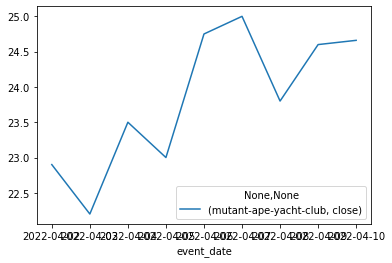

In [28]:
collection_slug = "mutant-ape-yacht-club"
file_name = collection_slug + '.csv'

df_mutant_ape = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_mutant_ape.plot()

In [29]:
num_of_simulation =100
num_of_years=1
num_trading_days = 252*num_of_years
num_trading_days=90

mutant_ape_MC = MCSimulation(
    portfolio_data = df_mutant_ape,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

In [30]:
# Printing the simulation input data
mutant_ape_MC.portfolio_data.head()

mutant-ape-yacht-club             
                           close daily_return
event_date                                   
2022-04-02                 22.90          NaN
2022-04-03                 22.20    -0.030568
2022-04-04                 23.50     0.058559
2022-04-05                 23.00    -0.021277
2022-04-06                 24.75     0.076087

In [31]:
# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
mutant_ape_MC.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.029056,1.029661,1.092356,0.991785,0.993522,1.020298,1.001853,1.047433,0.992955,1.029869,...,1.056981,1.057858,1.006400,1.013349,1.054302,1.039118,1.004958,1.058114,0.976216,1.047570
2,1.062381,1.033442,1.047108,0.998985,0.923951,0.978953,1.020133,1.108154,1.058662,1.042670,...,1.050963,1.044797,1.002006,1.026306,1.089987,1.040823,1.058855,1.174462,1.084435,1.034935
3,1.083783,1.063553,1.042509,1.043472,0.933696,0.941888,1.091452,1.107129,1.026373,0.992671,...,1.032022,1.088756,0.997994,1.105097,1.190443,1.026845,1.097668,1.168882,1.108504,1.028588
4,1.123028,1.018954,1.018951,1.022233,0.933492,0.985151,1.222617,1.131179,1.051540,0.995487,...,1.010116,1.140351,0.978092,1.118812,1.190707,0.917603,1.178151,1.135592,1.066389,1.067745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2.797490,2.117138,1.185834,1.961175,1.464268,2.229016,2.791089,2.552939,2.012934,2.347882,...,2.617813,2.848444,2.921475,2.983470,2.059344,2.145720,2.093090,2.318311,2.191202,2.226277
87,2.697717,2.156449,1.208844,1.833167,1.402486,2.237448,2.797590,2.548080,1.981945,2.407685,...,2.433096,2.766615,2.925320,3.104202,2.167291,2.135226,1.988648,2.329411,2.229999,2.245708
88,2.769978,2.298774,1.175763,1.812153,1.444351,2.212172,2.689135,2.474217,1.904994,2.321749,...,2.502454,2.871955,2.903186,2.960167,2.294924,2.251848,2.051182,2.441196,2.235587,2.086959
89,2.781495,2.318150,1.106230,1.824713,1.391680,2.028077,2.871871,2.357304,1.908299,2.314227,...,2.647723,2.898673,2.998676,2.993361,2.461309,2.408720,2.051923,2.340708,2.107053,2.183094


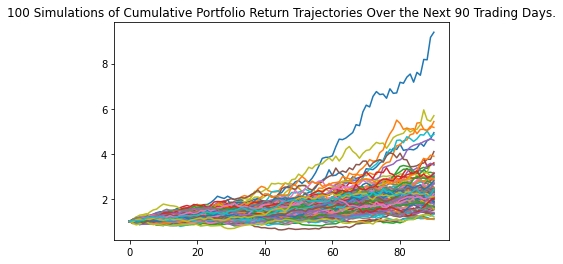

In [32]:
# Plot simulation outcomes
mutant_ape_line_plot = mutant_ape_MC.plot_simulation()
mutant_ape_line_plot.get_figure().savefig("mutant_ape_MC_sim_plot.png", bbox_inches="tight")

In [33]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = mutant_ape_MC.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           100.000000
mean              2.511028
std               1.155961
min               1.091581
25%               1.876079
50%               2.257965
75%               2.865327
max               9.391848
95% CI Lower      1.175581
95% CI Upper      5.307403
Name: 90, dtype: float64


In [34]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://lh3.googleusercontent.com/7B0qai02OdHA8P_EOVK672qUliyjQdQDGNrACxs7WnTgZAkJa_wWURnIFKeOh5VTf8cfTqW3wQpozGedaC9mteKphEOtztls02RlWQ=s120")

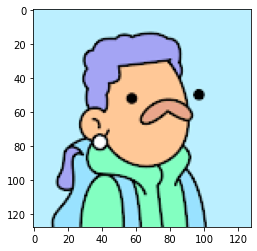

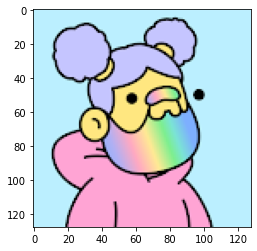

In [35]:
collection_base_url = "https://api.opensea.io/api/v1/collection/"
collection_slug="doodles-official"

def get_collection(collection_slug):
    collection_url = collection_base_url+collection_slug
    response = requests.request("GET", url)
    collection_json=response.json()
    return collection_json

#doodle_collection = get_collection(collection_slug)
#print(json.dumps(doodle_collection,indent=4))


asset_base_url = "https://api.opensea.io/api/v1/assets"

def get_asset(collection_slug,limit):
    headers = {
        "Accept": "application/json",
        "X-API-KEY": opensea_api_key
    }
    
    query = { 
        "include_orders":False,
        "collection_slug":collection_slug,
        "limit":limit
    }
    response = requests.request("GET", asset_base_url, headers=headers,params=query)
    return response.json()

asset_limit=200
doodle_assets_data=get_asset(collection_slug,asset_limit)
#print(json.dumps(doodle_assets,indent=4))
doodle_assets = doodle_assets_data["assets"]
#print(json.dumps(doodle_assets,indent=4))

def get_asset_image_urls(assets):
    asset_image_urls=[]
    for asset in assets:
        asset_image_thumbnail_url = asset["image_thumbnail_url"]
        asset_image_urls.append(asset_image_thumbnail_url)
    return asset_image_urls

asset_image_urls = get_asset_image_urls(doodle_assets)
#print(asset_image_urls)
#asset_image_urls
import random
import numpy as np
images =[]
from PIL import Image
random_url = np.random.choice(asset_image_urls)
#images.append(Image(url= random_url))

im = Image.open(requests.get(random_url, stream=True).raw)


images.append(im)
random_url = random.choice(asset_image_urls)
im1 = Image.open(requests.get(random_url, stream=True).raw)


images.append(im1)
#images.append(Image(url= random_url))
import matplotlib.pyplot as plt

for i in range(0,len(images)):
    plt.figure()
    plt.imshow(images[i])

In [36]:
def get_image(image):
    fig=plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.close(fig)
    return fig

img1 = get_image(im1)
img2 = get_image(im)

import panel as pn

image_rows1 = pn.Row(img1,img2)
image_rows2 = pn.Row(img1,img2)
image_column = pn.Column(
    image_rows1,
    image_rows2
)

image_column

ModuleNotFoundError: No module named 'panel'